# Recap LAB.5 Solutions

In this lab we do a comparison of the various dimensionality reduction methods. First we import the useful modules and download the dataset.

In [9]:
import numpy as np
import pandas as pd
import gzip
import struct
import sklearn
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

Downloading the dataset

In [10]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
        
Xtrain = read_idx('../Datasets/fashion_mnist//train-images-idx3-ubyte.gz')
ytrain=read_idx('../Datasets/fashion_mnist/train-labels-idx1-ubyte.gz')

Xtest = read_idx('../Datasets/fashion_mnist//t10k-images-idx3-ubyte.gz')
ytest =read_idx('../Datasets/fashion_mnist/t10k-labels-idx1-ubyte.gz')

<ipython-input-10-d9e5d408afbd>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


Let's do a train test split, and use a subsection of the all dataset. We normalize to have all images between [0, 1]

In [11]:
Xtrain, _, ytrain, _ = train_test_split(Xtrain, ytrain, train_size = 5000, random_state=0)
_, Xtest, _, ytest = train_test_split(Xtest, ytest, test_size = 100, random_state=0)

# printing shapes
print(f'Train shape: {Xtrain.shape}')
print(f'Test shape: {Xtrain.shape}')

# normalizing
Xtrain = Xtrain/255
Xtest = Xtest/255 

# reshaping
Xtrain = Xtrain.reshape((Xtrain.shape[0],-1))
Xtest = Xtest.reshape((Xtest.shape[0],-1))

Train shape: (5000, 28, 28)
Test shape: (5000, 28, 28)


We start with the exercise, let's import the useful modules

In [12]:
from reduction import PCA, KernelPCA            # our implementation
from sklearn.manifold import Isomap, TSNE       # implementation sklearn
import torch

Let's make a simple function for visualization

In [13]:
def plot_latent(latent, classes, title):
    cmap = plt.get_cmap('jet', 10)
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(1, 2, 1)
    p = ax.scatter(latent[:, 0], latent[:, 1], c=classes, cmap=cmap)

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(latent[:, 0], latent[:, 1], latent[:, 2], c=classes, cmap=cmap)
    cb = plt.colorbar(p, location='left')
    cb.ax.set_title('Class', fontsize=11)
    plt.gca().set_title(title, fontsize=20)
    plt.show()


We start by visualizig **PCA**

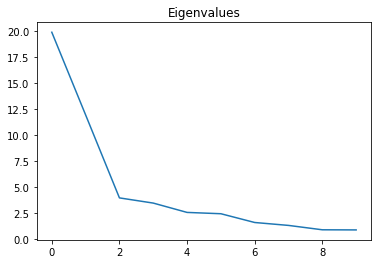

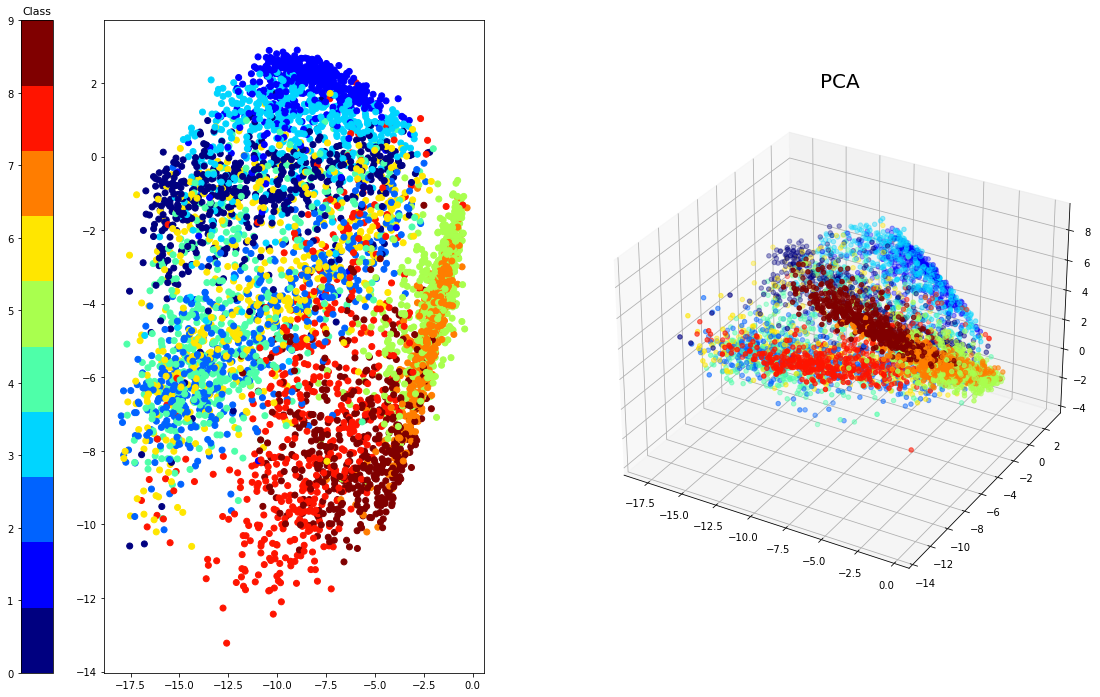

In [14]:
pca = PCA()
pca.fit(Xtrain)
X_pca = pca.transform(Xtrain)

# plotting eigenvalues (first 10 components)
plt.title('Eigenvalues')
plt.plot(range(10), pca.eigenvalues[:10])
plt.show()

# plotting latent spaces
plot_latent(X_pca, ytrain, 'PCA')


Let's visualize kernel PCA, we start with gaussian kernel

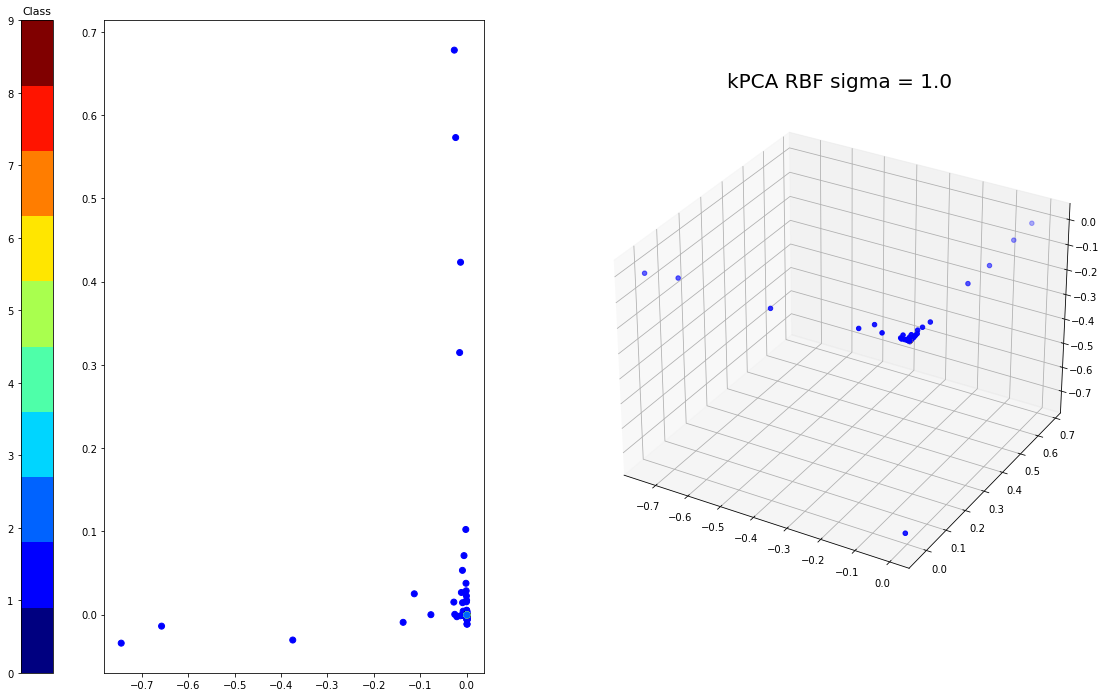

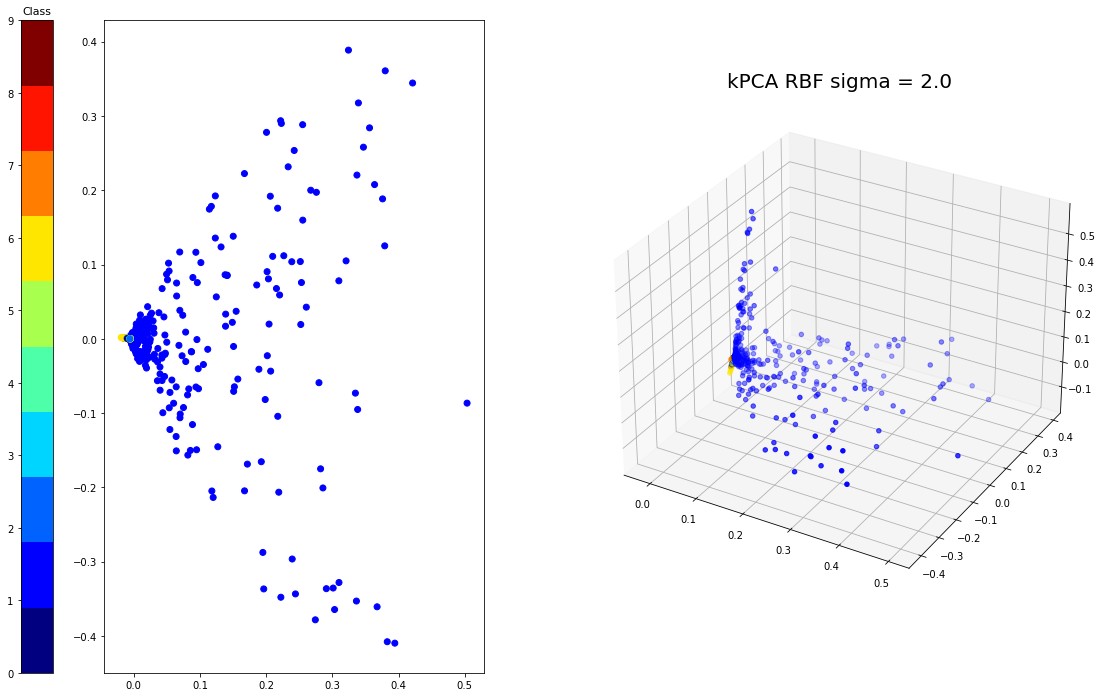

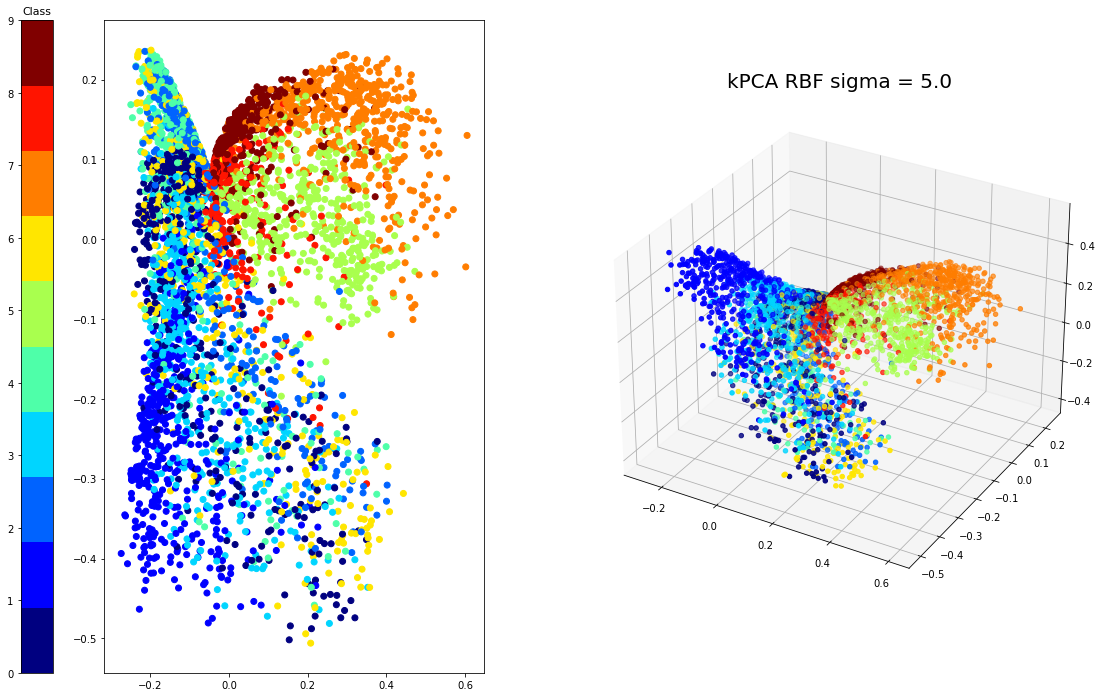

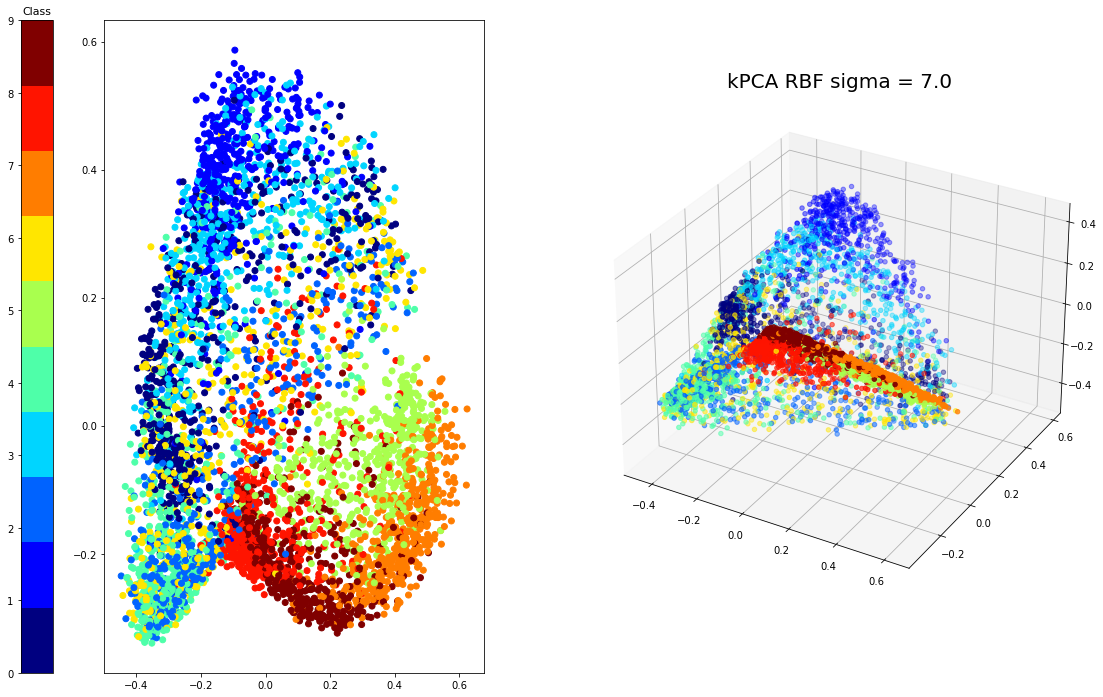

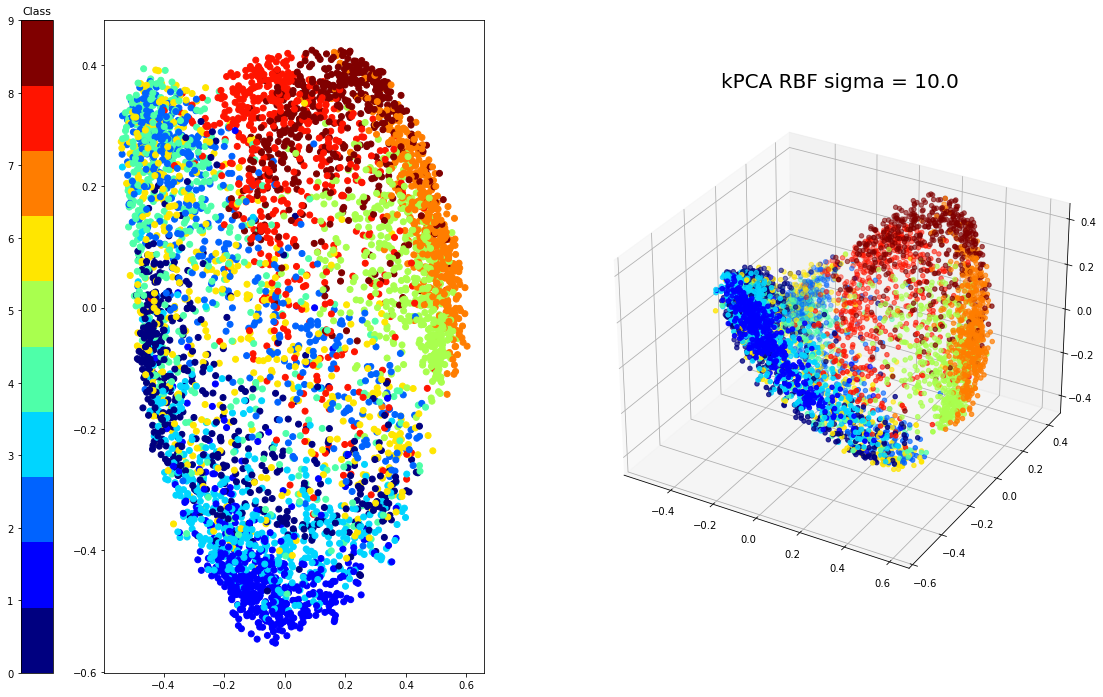

In [15]:
for sigma in (1., 2., 5., 7., 10.):
    kpca = KernelPCA('gaussian', gamma=(sigma)**(-2))
    X_kpca = kpca.fit_transform(Xtrain, numb_components=3)
    plot_latent(X_kpca, ytrain, f'kPCA RBF sigma = {sigma}')

We now try for polynomial kernel

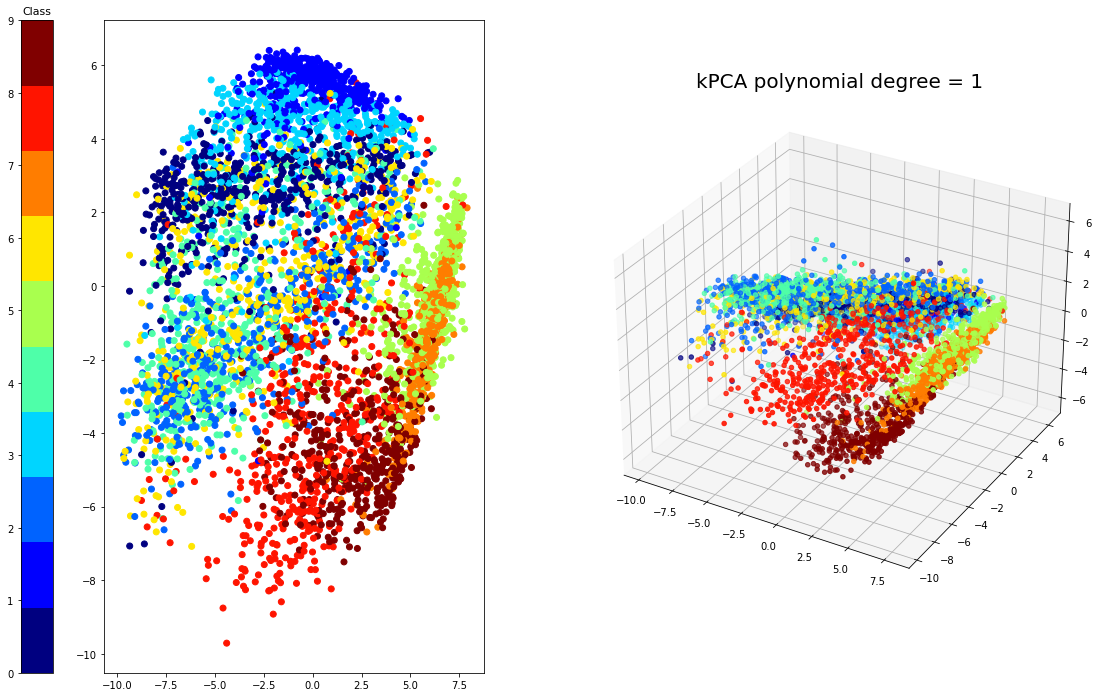

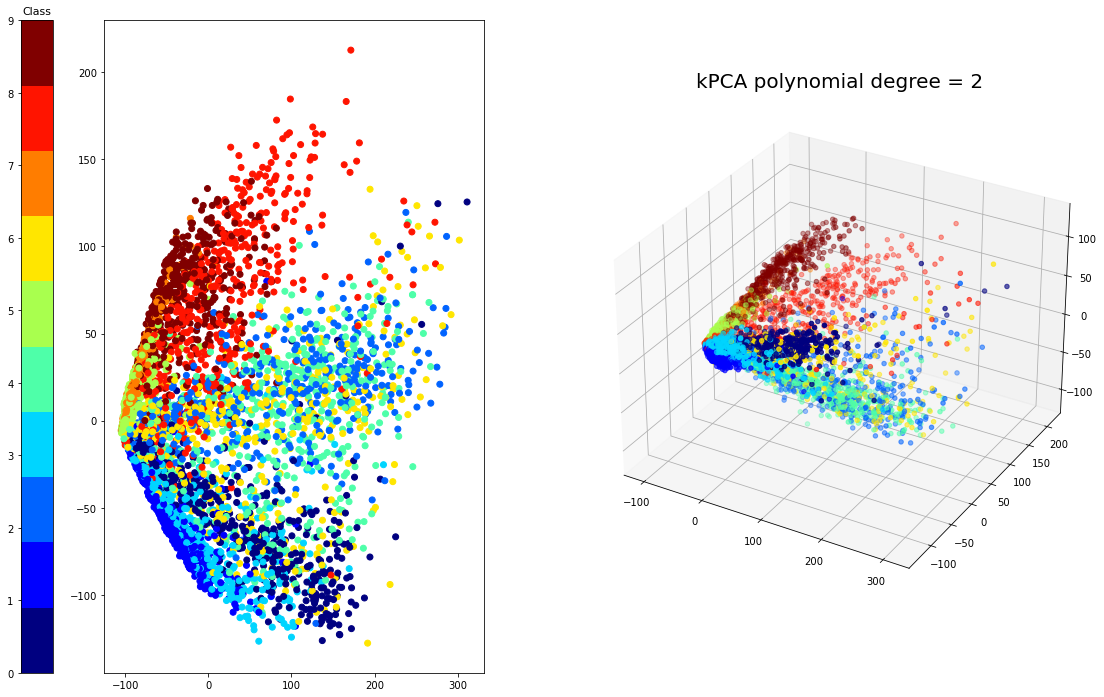

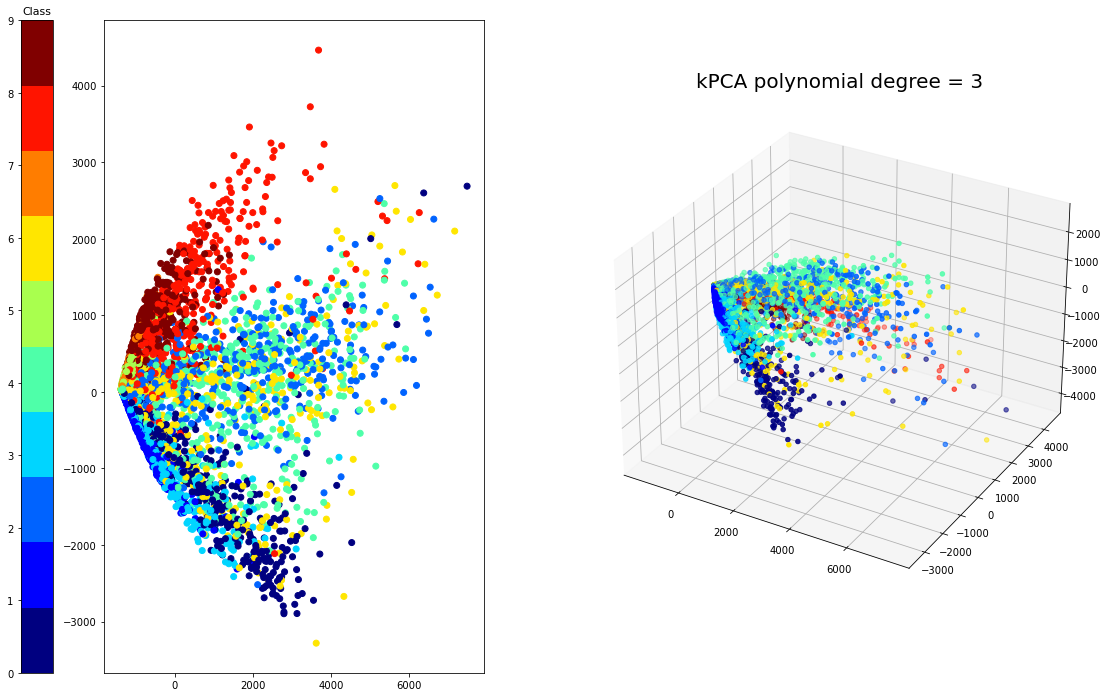

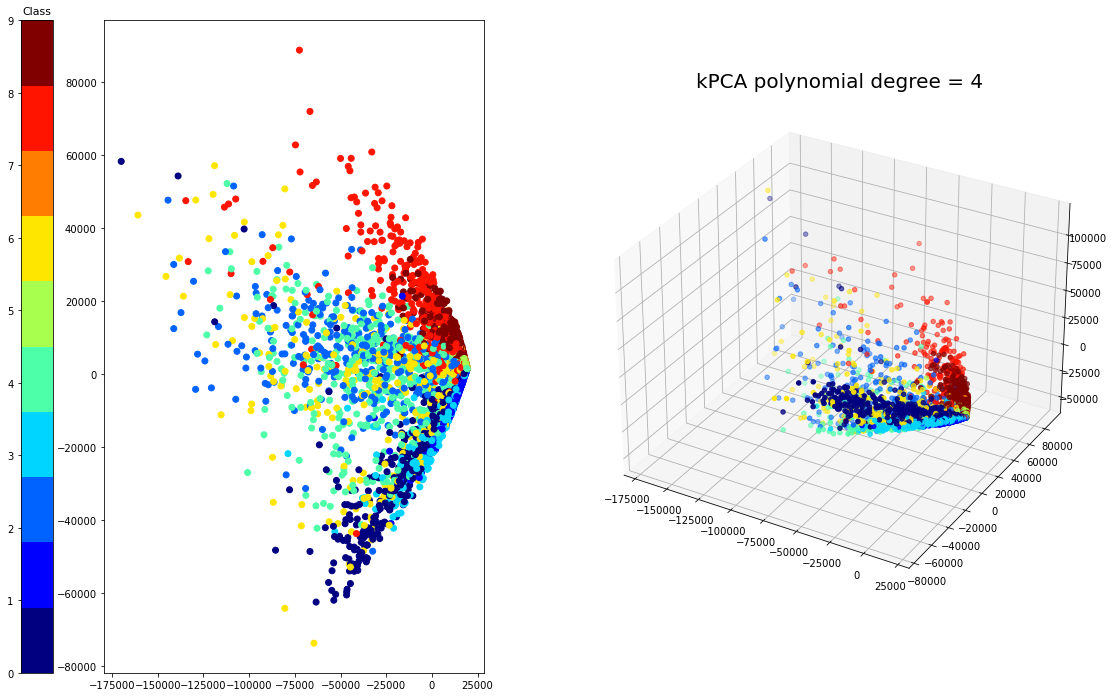

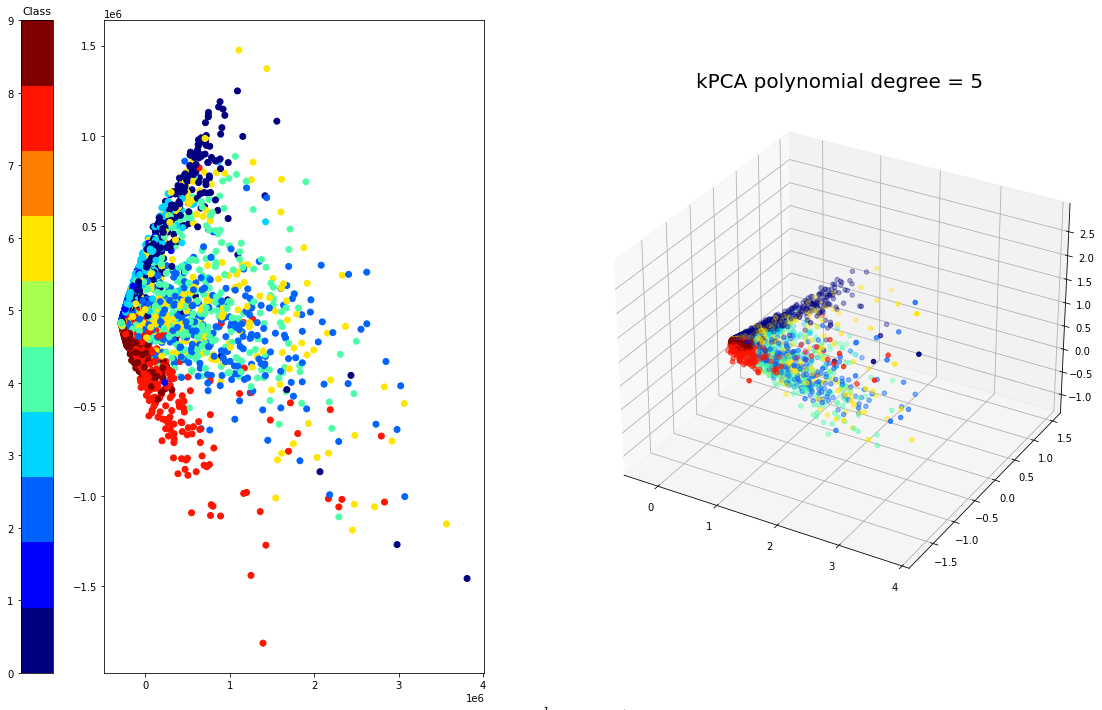

In [18]:
for degree in range(1, 6):
    kpca = KernelPCA('poly', gamma=degree)
    X_kpca = kpca.fit_transform(Xtrain, numb_components=3)
    plot_latent(X_kpca, ytrain, f'kPCA polynomial degree = {degree}')

We now use the sklearn **ISOMAP** and **TSNE** implementation.

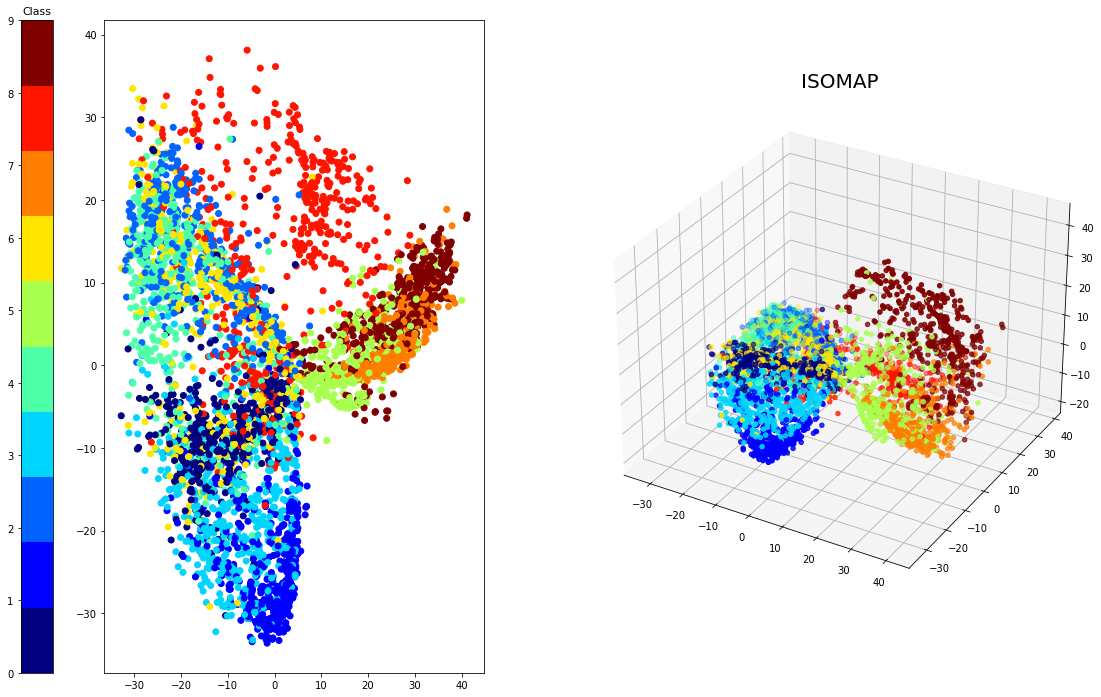

In [19]:
isomap = Isomap(n_components=3, path_method='FW')
X_isomap = isomap.fit_transform(Xtrain)
plot_latent(X_isomap, ytrain, 'ISOMAP')

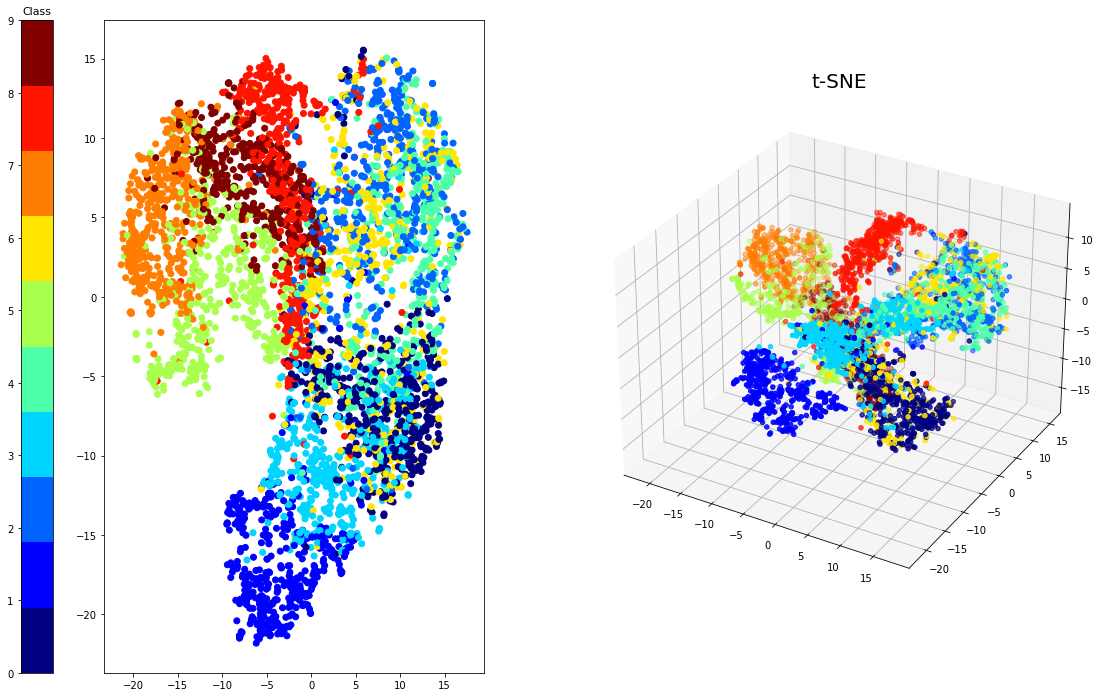

In [20]:
tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(Xtrain)
plot_latent(X_tsne, ytrain, 't-SNE')

Finally we use an autoencoder for reducing

In [44]:
class Autoencoder(torch.nn.Module):
    def __init__(self,  dim):
        super().__init__()

        self.dim = dim
        self.encoder = torch.nn.Sequential(torch.nn.Linear(in_features=28*28, out_features=256),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=256, out_features=32),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(32,self.dim)
                                           )
        self.decoder = torch.nn.Sequential(torch.nn.Linear(in_features=self.dim, out_features=32),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=32, out_features=256),
                                           torch.nn.LeakyReLU(),
                                           torch.nn.Linear(in_features=256, out_features=28*28)
                                           )

        self.ae = torch.nn.Sequential(self.encoder, self.decoder)
                                           
    def forward(self, x):
        return self.ae(x)

    def fit_transform(self, x, train_loader, val_loader, 
                      loss_func=torch.nn.MSELoss, optimizer=torch.optim.Adam,
                      learning_rate = 0.01,
                      num_epochs=50):
        
        model = self.ae
        optim = optimizer(model.parameters(), lr=learning_rate)
        loss_func = loss_func()
        l_train =[]
        l_val = []

        for epoch in range(num_epochs+1): 
            model.train()
            loss_tr=[]

            for step, (images_raw, images_out) in enumerate(train_loader):
                y = model(images_raw)
                loss = loss_func(images_out, y)
                loss_tr.append(loss.detach().item())
                optim.zero_grad()
                loss.backward()
                optim.step()

            model.eval()
            loss_ts = []
            for step, (images_raw, images_out) in enumerate(val_loader):
                y = model(images_raw)
                loss = loss_func(images_out, y)       
                loss_ts.append(loss.detach().cpu().numpy())
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, training_loss: {np.mean(loss_tr)}, validation_loss {np.mean(loss_ts)}")

            l_train.append(np.mean(loss_tr))
            l_val.append(np.mean(loss_ts))


# make training loader
train_set = torch.utils.data.TensorDataset(torch.tensor(Xtrain, dtype=torch.float), torch.tensor(Xtrain, dtype=torch.float))
train_set, val_set = torch.utils.data.random_split(train_set, [round(len(train_set) * 0.8), round(len(train_set) * 0.2)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

# build the autoencoder
ae = Autoencoder(3)
ae.fit_transform(Xtrain, train_loader, val_loader, num_epochs=100)


Epoch 0, training_loss: 0.08282043726649135, validation_loss 0.061415910720825195
Epoch 10, training_loss: 0.027104727050755173, validation_loss 0.02726808376610279
Epoch 20, training_loss: 0.024821170838549733, validation_loss 0.026350341737270355
Epoch 30, training_loss: 0.024136552237905562, validation_loss 0.025588735938072205
Epoch 40, training_loss: 0.023654852353502065, validation_loss 0.02634439989924431
Epoch 50, training_loss: 0.02267761860275641, validation_loss 0.024556629359722137
Epoch 60, training_loss: 0.022499012644402683, validation_loss 0.024570494890213013
Epoch 70, training_loss: 0.02210978011135012, validation_loss 0.02408955618739128
Epoch 80, training_loss: 0.021882736182305962, validation_loss 0.02393157035112381
Epoch 90, training_loss: 0.022289507498499006, validation_loss 0.02551010251045227
Epoch 100, training_loss: 0.021268270444124937, validation_loss 0.024022119119763374


Let's visualize the representation

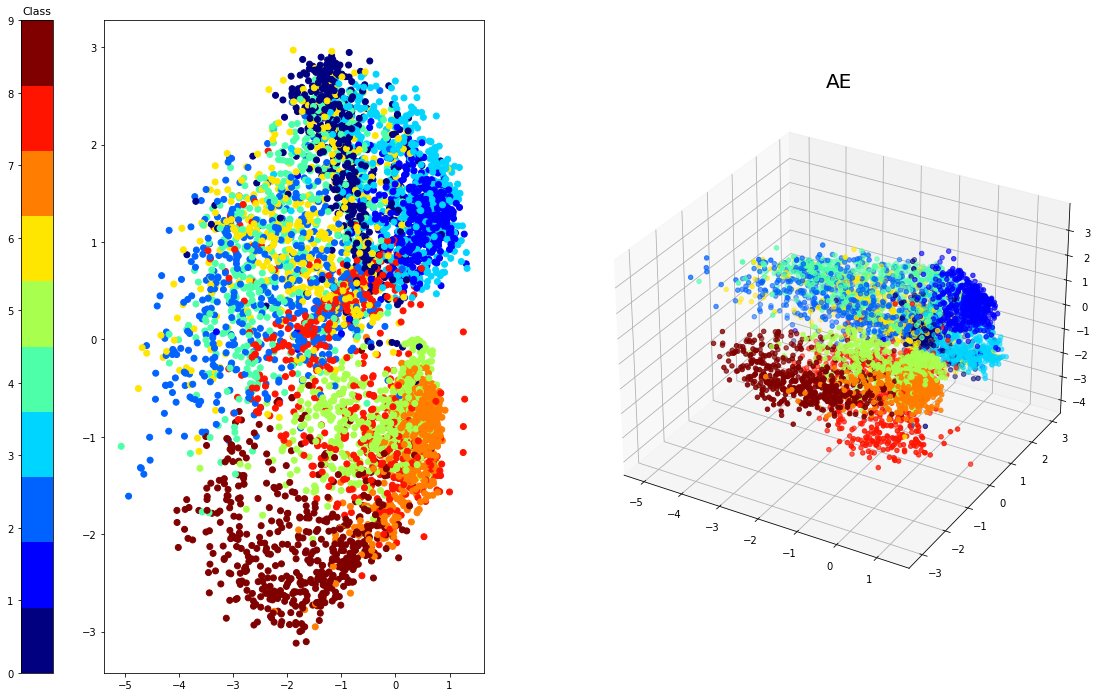

In [45]:
plot_latent(ae.encoder(train_set.dataset.tensors[0]).detach(), ytrain, 'AE')

We can also plot the reconstruction

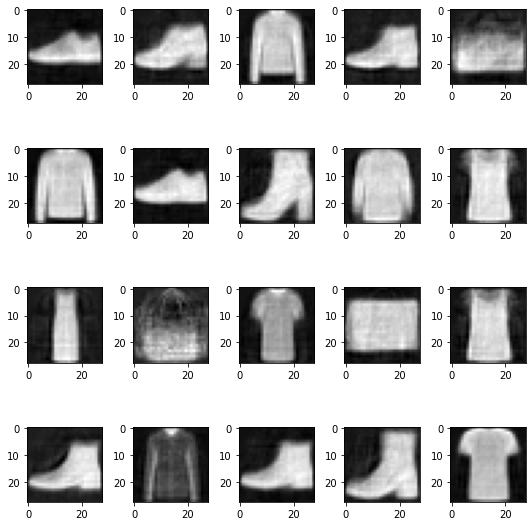

In [74]:
# make test set
test_set = torch.utils.data.TensorDataset(torch.tensor(Xtest, dtype=torch.float), torch.tensor(ytest, dtype=torch.float).reshape(-1, 1))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

n_row = 4
n_col = 5
images=Xtrain[:n]
labels=ytrain[:n]

fig, axes=plt.subplots(n_row, n_col, figsize=(1.5*n_col, 2*n_row))
for i, (images_raw, labels) in enumerate(test_loader):
    y = ae.ae(images_raw)
    images = y.detach().numpy()[0].reshape(28, 28)
    ax = axes[i//n_col, i%n_col]
    ax.imshow(images, cmap='gray')
    if i == n_col*n_row - 1:
        break
plt.tight_layout()
plt.show()

As we can see the reconstructions look really good.